# Today's Coaches

- [Mosky Liu](https://github.com/moskytw)
- [Mei-Hua Pan](https://github.com/crazyplum)


# The Code and Data

- The code and the minimal data → https://github.com/moskytw/mining-news
- The full data → ask from coaches.


# Machine Learning Process

This notebook will base on the process:

1. Define Problem
2. Prepare Data
3. Train and Evaluate
4. Deployment


# Define Problem

究竟一篇新聞在 PTT 會不會被噓呢？<br>
↑ 太難用英文寫了，哈哈哈哈。

<small>We will keep using English in this notebook, since most of the data mining documentations are written in English. You have to be used to it. 😆</small>

## PTT Terms in English

- 文章: article
- 標題: title
- 推文: push
- 推: push score +1
- 噓: push score -1
- 被噓: sum(push scores) <= -1

## Choosing Model(s)

We are categorizing the articles. Simply pick some from the [cheat sheet](http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html).


# Prepare Data

We prepared for you. Here we will let you know the scripts and the flow.

## Crawl and Preprocess

Download the HTML, and process them into JSON (∵ more machine-friendly).

### 1. ptt_crawling.py

(PTT web) → `cache/*.html`

### 2. ptt_preproc_to_json.py

`cache/*.html` → `preprocessed/*.json`

### 3. ptt_preproc_filtering.py

It removes articles whcih are out-of-range in `preprocessed/`. It configured to keep the articles during 2016/7–2016/11 (5 months).

### 4. ptt_preproc_sampling.py

It keeps 10,000 JSONs in `preprocessed/` for faster experiment.

### 5. ptt_preproc_to_target.py

`preprocessed/*.json` → `targets/*.txt`

Each text file has a corresponding push score sum.

### 6. ptt_corpus_tokenizer.py

- tokenize: `preprocessed/*.json` → `corpus.txt`
- `targets/*.txt` → `targets.txt`

The `corpus.txt` will be the input, and `target.txt` will be the expected output.

Now we only take the title to tokenize.

#### Tokenizing

We have used the libs to tokenize.

1. [jieba](https://github.com/fxsjy/jieba) and its [tranditional Chinese dictionary](https://github.com/fxsjy/jieba#其他词典)
2. [Zhon](https://github.com/tsroten/zhon)

#### Command Line Usage Example

    python3 ptt_corpus_tokenizer.py \
        --preprocessed-dir preprocessed/ \
        --targets-dir targets/ \
        --corpus-output corpus.txt \
        --target-output target.txt

## Explore Data

Now we get the well-formatted data. Before we start training a model, take a look to know them better.

Here are two important theories to work with text:

### tf-idf

It's term frequency–inverse document frequency.

- tf: term frequency = (a term count in a doc) / (all terms count in the doc)
- df: document frequency = (docs count having the term) / (all docs count)
- idf: inverse document frequency = log(1 / df)
- tf-idf = tf × idf

### n-gram

An n-gram is a contiguous sequence of n items from a given sequence of text or speech.

If the unit is a word,

- 1-gram: to be or not to be → to, be, or, not, to, be (same)
- 2-gram: to be or not to be → to be, be or, or not, not to, to be
- etc.

And the docs entries:

### Pandas, NumPy, and SciPy

We will use them a bit, but won't explain them too much, please refer to the docs:

- [pandas API Reference](http://pandas.pydata.org/pandas-docs/stable/api.html)
- [NumPy Reference](https://docs.scipy.org/doc/numpy/reference/)
- [SciPy Reference Guide](https://docs.scipy.org/doc/scipy/reference/)

Or the tutorials:

- [10 Minutes to pandas](http://pandas.pydata.org/pandas-docs/stable/10min.html)
- [NumPy Quickstart Tutorial](https://docs.scipy.org/doc/numpy-dev/user/quickstart.html)
- [SciPy Tutorial](https://docs.scipy.org/doc/scipy/reference/tutorial/index.html)

### See Also

1. [EDA, Exploratory data analysis – Wikipedia](https://en.wikipedia.org/wiki/Exploratory_data_analysis)
2. [Tf-idf – Example – Wikipedia](https://en.wikipedia.org/wiki/Tf%E2%80%93idf#Example_of_tf.E2.80.93idf)
3. [N-gram – Example – Wikipedia](https://en.wikipedia.org/wiki/N-gram#Examples)
4. [Text Feature Extraction – scikit-learn](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)

In [1]:
# init for plotting

%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')

# init the utils

import numpy as np
import pandas as pd

### Explore the Terms

What are the important terms?

#### The First Try

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

# doc: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
vectorizer = CountVectorizer(
    # the default regex select tokens of 2+ alphanumeric characters
    # it filters 催 停 到 from 催 太猛 停車 停 到 衝進 藥局,
    # but they are significant in Chinese, we rewrite a regex here
    token_pattern=r'(?u)\b\w+\b',
    # unigram and bigram
    # unigram: 催 / 太猛 / 衝進 -> 催 / 太猛 / 衝進
    # bigram: 催 / 太猛 / 衝進 -> 催 太猛 / 太猛 衝進
    ngram_range=(1, 2)
)

In [3]:
# smat: sparse matrix
input_term_count_smat = vectorizer.fit_transform([
    '新聞 中午 吃 什麼',
    '新聞 急症 沒錢醫',
])

print(vectorizer.get_feature_names())
# rows are inputs
# columns are counts of a feature
print(input_term_count_smat.toarray())

['中午', '中午 吃', '什麼', '吃', '吃 什麼', '急症', '急症 沒錢醫', '新聞', '新聞 中午', '新聞 急症', '沒錢醫']
[[1 1 1 1 1 0 0 1 1 0 0]
 [0 0 0 0 0 1 1 1 0 1 1]]


In [4]:
with open('corpus.txt') as f:
    print(next(f), end='')
    print(next(f), end='')
    print(next(f), end='')

新聞 被控 電影院 毆女 知名 中學 前 家長 會長 反擊
新聞 E 奶 女星 痛 譙 變態 秦偉 之亂 暴增 6 名 受害者
新聞 Hebe 生活 影片 宣傳 新作 粉絲 想 看 洗澡 反


In [5]:
with open('corpus.txt') as f:
    input_term_count_smat = vectorizer.fit_transform(f)

In [6]:
# mat: matrix
term_count_mat = input_term_count_smat.sum(axis=0)
term_count_arr = np.asarray(term_count_mat).reshape(-1)
sorted_term_count_arr = np.sort(term_count_arr)

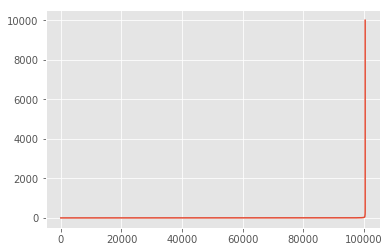

In [7]:
# doc: http://pandas.pydata.org/pandas-docs/stable/visualization.html
sorted_term_count_s = pd.Series(sorted_term_count_arr)
sorted_term_count_s.plot()

In [8]:
sorted_term_count_s.describe()

count    100356.000000
mean          1.864861
std          32.213412
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max       10005.000000
dtype: float64

In [9]:
vectorizer.stop_words_

set()

In [10]:
feature_names = vectorizer.get_feature_names()
sorted_term_idx_arr = np.argsort(term_count_arr)

n = 10

print('Top', n, 'terms and counts:')
print()
for term_idx in sorted_term_idx_arr[:-n:-1]:
    print(feature_names[term_idx], term_count_arr[term_idx])

Top 10 terms and counts:

新聞 10005
被 564
的 518
了 429
不 378
是 347
人 309
蔡 287
台灣 279


#### The Second Try

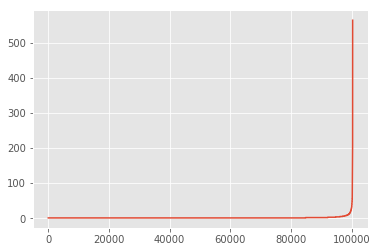

In [11]:
vectorizer_2 = CountVectorizer(
    min_df=1, max_df=0.5,
    token_pattern=r'(?u)\b\w+\b',
    ngram_range=(1, 2)
)

with open('corpus.txt') as f:
    input_term_count_smat_2 = vectorizer_2.fit_transform(f)
    
term_count_mat_2 = input_term_count_smat_2.sum(axis=0)
term_count_arr_2 = np.asarray(term_count_mat_2).reshape(-1)
sorted_term_count_arr_2 = np.sort(term_count_arr_2)

sorted_term_count_s_2 = pd.Series(sorted_term_count_arr_2)
sorted_term_count_s_2.plot()

In [12]:
sorted_term_count_s_2.describe()

count    100355.000000
mean          1.765184
std           6.372356
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         564.000000
dtype: float64

In [13]:
vectorizer_2.stop_words_

{'新聞'}

In [14]:
feature_names = vectorizer_2.get_feature_names()
sorted_term_idx_arr = np.argsort(term_count_arr_2)

n = 10

print('Top', n, 'terms and counts:')
print()
for term_idx in sorted_term_idx_arr[:-n:-1]:
    print(feature_names[term_idx], term_count_arr_2[term_idx])

Top 10 terms and counts:

被 564
的 518
了 429
不 378
是 347
人 309
蔡 287
台灣 279
遭 270


### Explore the Push Score Sums

What are the output we wanna predict?

In [15]:
with open('target.txt') as f:
    print(next(f), end='')
    print(next(f), end='')
    print(next(f), end='')

12
21
4


In [16]:
with open('target.txt') as f:
    push_score_sums = [int(line) for line in f]

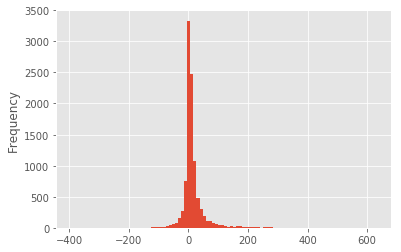

In [17]:
push_score_sum_s = pd.Series(push_score_sums)
push_score_sum_s.plot.hist(bins=100)

In [18]:
push_score_sum_s.describe()

count    10000.000000
mean        15.098200
std         44.458338
min       -392.000000
25%          1.000000
50%          7.000000
75%         18.000000
max        630.000000
dtype: float64

# Train and Evaluate

## Load Input and Expected Output In

Use the findings from the previous section.

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

# doc: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
vectorizer = TfidfVectorizer(
    min_df=1, max_df=0.5,
    token_pattern=r'(?u)\b\w+\b',
    ngram_range=(1, 2)
)

with open('corpus.txt') as f:
    X = vectorizer.fit_transform(f)
    
with open('target.txt') as f:
    # let's use -1 to represent 被噓, and 0 for other cases
    y = [-1 if int(line) <= -1 else 0 for line in f]

## Split Training Set and Testing Set

We split some for training model, some for validating. 

In [20]:
from sklearn.model_selection import train_test_split

# doc: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## First Try

SVM: [Support Vector Machines – scikit-learn](http://scikit-learn.org/stable/modules/svm.html#support-vector-machines)

### SVM's Hyper-Plane

![SVM's Hyper-Plane](http://scikit-learn.org/stable/_images/sphx_glr_plot_separating_hyperplane_0011.png)

In [21]:
from sklearn import svm
from sklearn.metrics import classification_report

# doc: http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
svc = svm.SVC(kernel='linear', C=1, class_weight='balanced')

print('SVC')
print()

%time svc.fit(X_train, y_train)
print()

# doc: http://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score
print('Traning Set Accuracy:', svc.score(X_train, y_train))
print('Validation Accuracy:', svc.score(X_test, y_test))
print()

print(classification_report(y_test, svc.predict(X_test)))

SVC

CPU times: user 8.59 s, sys: 228 ms, total: 8.82 s
Wall time: 8.93 s

Traning Set Accuracy: 0.993857142857
Validation Accuracy: 0.810333333333

             precision    recall  f1-score   support

         -1       0.56      0.25      0.35       603
          0       0.83      0.95      0.89      2397

avg / total       0.78      0.81      0.78      3000



### Precision and Recall

![Precision and Recall](https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg)

### F1 Score

![F1Score](https://wikimedia.org/api/rest_v1/media/math/render/svg/7d63c1f5c659f95b5dfe5893213cc8ea7f8bea0a)

A F1 score is the harmonic mean of precision and recall. See [F1 score](https://en.wikipedia.org/wiki/F1_score) for details.

## Explore the Trained Model

Know the data even deeper.

In [22]:
class_i = 0
n = 10

feature_names = vectorizer.get_feature_names()
sorted_feature_idx_arr = np.argsort(svc.coef_.toarray())[class_i]

In [23]:
print('Top', n, 'positive features:')
print()

for fidx in sorted_feature_idx_arr[:-n:-1]:
    print(feature_names[fidx], svc.coef_[class_i, fidx])
    
print()
    
print('Top', n, 'negative features:')
print()

for fidx in sorted_feature_idx_arr[:n]:
    print(feature_names[fidx], svc.coef_[class_i, fidx])

Top 10 positive features:

美 1.49081155042
20 1.19937534089
泰國 1.18790931177
美國 1.11804937332
抗議 1.01609857754
日本 0.992017621316
年 0.93827629264
杜特蒂 0.91317068476
反同 0.909715194003

Top 10 negative features:

歐陽 -2.61933393496
吳秉叡 -2.55979999573
小s -2.52602534262
洪秀柱 -2.5077794054
黑人 -2.33544331716
兩岸 -2.28616224413
柯建銘 -2.06086631084
小英 -2.00811527009
勞動部 -2.0025928574
蔡 -1.98853279842


## Feature Selection

Improve models' accuracy scores or to boost their performance – [Feature Selection - scikit-learn](http://scikit-learn.org/stable/modules/feature_selection.html#feature-selection).

In [24]:
# doc: http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
lsvc = svm.LinearSVC(C=1, penalty='l1', dual=False)

print('Linear SVC')
print()

%time lsvc.fit(X_train, y_train)
print()

print('Training Set Shape:', X_train.shape)
print('Traning Set Accuracy:', lsvc.score(X_train, y_train))
print('Validation Accuracy:', lsvc.score(X_test, y_test))
print()

print(classification_report(y_test, lsvc.predict(X_test)))

Linear SVC

CPU times: user 227 ms, sys: 14.7 ms, total: 242 ms
Wall time: 297 ms

Training Set Shape: (7000, 100355)
Traning Set Accuracy: 0.877142857143
Validation Accuracy: 0.811

             precision    recall  f1-score   support

         -1       0.59      0.20      0.30       603
          0       0.83      0.96      0.89      2397

avg / total       0.78      0.81      0.77      3000



In [25]:
from sklearn.feature_selection import SelectFromModel

# doc: http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html
sfm = SelectFromModel(lsvc, prefit=True)
X_train_2 = sfm.transform(X_train)
X_test_2 = sfm.transform(X_test)

lsvc_2 = svm.LinearSVC(C=1, penalty='l1', dual=False)

print('Linear SVC #2')
print()

%time lsvc_2.fit(X_train_2, y_train)
print()

print('Training Set Shape:', X_train_2.shape)
print('Traning Set Accuracy:', lsvc_2.score(X_train_2, y_train))
print('Validation Accuracy:', lsvc_2.score(X_test_2, y_test))
print()

print(classification_report(y_test, lsvc_2.predict(X_test_2)))

Linear SVC #2

CPU times: user 26.5 ms, sys: 592 µs, total: 27.1 ms
Wall time: 27.7 ms

Training Set Shape: (7000, 1264)
Traning Set Accuracy: 0.877142857143
Validation Accuracy: 0.811

             precision    recall  f1-score   support

         -1       0.59      0.20      0.30       603
          0       0.83      0.96      0.89      2397

avg / total       0.78      0.81      0.77      3000



## Model Selection

Select the best model. See [Model Selection – scikit-learn](http://scikit-learn.org/stable/model_selection.html) for the full doc.

In [26]:
from sklearn.model_selection import GridSearchCV

# CV: Cross-Validation, http://scikit-learn.org/stable/modules/cross_validation.html
# Grid Search: http://scikit-learn.org/stable/modules/grid_search.html
# doc: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
gscv = GridSearchCV(
    svm.LinearSVC(),
    {'C': [1, 10, 100, 1000]},
    cv=5
)

print('Grid Search CV on LinearSVC')
print()

%time gscv.fit(X_train, y_train)
print()

print('Best Parameters:', gscv.best_params_)
print('Best Traning Set Accuracy:', gscv.best_score_)

Grid Search CV on LinearSVC

CPU times: user 16.7 s, sys: 201 ms, total: 16.9 s
Wall time: 18.7 s

Best Parameters: {'C': 100}
Best Traning Set Accuracy: 0.818428571429


In [27]:
best_lsvc = svm.LinearSVC(**gscv.best_params_)

print('Best Linear SVC')
print()

%time best_lsvc.fit(X_train, y_train)
print()

print('Traning Set Accuracy:', best_lsvc.score(X_train, y_train))
print('Validation Accuracy:', best_lsvc.score(X_test, y_test))
print()

print(classification_report(y_test, best_lsvc.predict(X_test)))

Best Linear SVC

CPU times: user 1.34 s, sys: 6.16 ms, total: 1.35 s
Wall time: 1.35 s

Traning Set Accuracy: 0.999
Validation Accuracy: 0.813666666667

             precision    recall  f1-score   support

         -1       0.60      0.21      0.31       603
          0       0.83      0.96      0.89      2397

avg / total       0.78      0.81      0.78      3000



# Your Turn

1. Try to use [.predict](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC.predict) to predict an unknown news.
2. Add more features? e.g., adding `author_id` by [Dict Vectorizer](http://scikit-learn.org/stable/modules/feature_extraction.html#dict-feature-extraction).
3. Predict more categories? e.g., sum(push scores) >= 10.
4. Try other kernel of SVM? e.g., [RBF](http://scikit-learn.org/stable/modules/svm.html#svm-kernels).

# References

1. Supervised Machine Learning – why & how to apply by 朱伯憲
2. [Data mining – process – Wikipedia](https://en.wikipedia.org/wiki/Data_mining#Process)

In [28]:
from ptt_corpus_tokenizer import preprocess_and_tokenizie
best_lsvc.predict(vectorizer.transform([
    preprocess_and_tokenizie('[新聞] 爭風吃醋！國中生臉書約談判　持西瓜刀'),
    preprocess_and_tokenizie('[新聞] 「炫妻狂魔」黑人狂PO范范美照　引古詞讚'),
    preprocess_and_tokenizie('[新聞] 分手後驚覺懷孕！前女友轉生氣　怒告男：'),
]))

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/b2/yfs3c8615jj6xq25081vvk7r0000gn/T/jieba.cache
Loading model cost 1.163 seconds.
Prefix dict has been built succesfully.


array([ 0, -1,  0])